# Ants Bees VGG16 による解析

# Fitting 

In [ ]:
%pwd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pillow==6.2.1

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 748.9 MB 600 bytes/s 
     |████████████████████████████████| 8.8 MB 20.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.2.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.2.0 which is incompatible.
     |████████████████████████████████| 2.1 MB 5.0 MB/s 
  Attempting uninstall: pillow
 

In [ ]:
data_dir = '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data'
root_dir= '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data'

In [ ]:
'''
3. 前処理前後の画像を確認する
'''
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import torch
import torch.utils.data as data
from pathlib import Path


In [ ]:
'''
2. 前処理クラスの定義
'''
class ImageTransform():
    '''画像の前処理クラス。訓練時、検証時で異なる動作をする。

    Attributes:
      data_transform(dic):
        train: 訓練用のトランスフォーマーオブジェクト
        val  : 検証用のトランスフォーマーオブジェクト
    '''

    def __init__(self, resize, mean, std):
        '''トランスフォーマーオブジェクトを生成する。

        Parameters:
        resize(int): リサイズ先の画像の大きさ
        mean(tuple): (R, G, B)各色チャネルの平均値
        std        : (R, G, B)各色チャネルの標準偏差
        '''
        # dicに訓練用、検証用のトランスフォーマーを生成して格納
        self.data_transform = {
            'train': transforms.Compose([
                # ランダムにトリミングする
                transforms.RandomResizedCrop(
                    resize, # トリミング後の出力サイズ
                    scale=(0.5, 1.0)),  # スケールの変動幅
                transforms.RandomHorizontalFlip(p = 0.5),  # 0.5の確率で左右反転
                transforms.RandomRotation(15),  # 15度の範囲でランダムに回転
                transforms.ToTensor(),          # Tensorオブジェクトに変換
                transforms.Normalize(mean, std) # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),      # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeでトリミング
                transforms.ToTensor(),          # テンソルに変換
                transforms.Normalize(mean, std) # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        '''オブジェクト名でコールバックされる
        Parameters:
          img: 画像
          phase(str): 'train'または'val' 前処理のモード
        '''
        return self.data_transform[phase](img) # phaseはdictのキー


### 前処理前後の画像を確認する


In [ ]:
tt='hymenoptera_data/'+'train'+'/bees/2405441001_b06c36fa72.jpg'
image_file_path = os.path.join(data_dir,tt)
print(image_file_path)

/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg


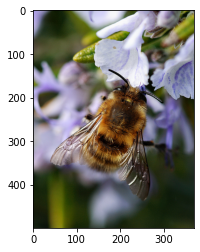

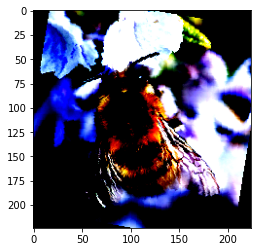

In [ ]:

%matplotlib inline

# サンプル画像を1枚読み込む
image_file_path = os.path.join(data_dir,'hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg')
img = Image.open(image_file_path)   # (高さ, 幅, RGB)

# 元の画像の表示
plt.imshow(img)
plt.show()

# 画像の前処理と処理済み画像の表示
# モデルの入力サイズ(タテ・ヨコ)
SIZE = 224
# 標準化する際の各RGBの平均値
MEAN = (0.485, 0.456, 0.406) # ImageNetデータセットの平均値を使用
# 標準化する際の各RGBの標準偏差
STD = (0.229, 0.224, 0.225)  # ImageNetデータセットの標準偏差を使用

# トランスフォーマーオブジェクトを生成
transform = ImageTransform(SIZE, MEAN, STD)
# 訓練モードの前処理を適用、torch.Size([3, 224, 224])
img_transformed = transform(img, phase="train")

# (色、高さ、幅)を (高さ、幅、色)に変換
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
# ピクセル値を0～1の範囲に制限して表示
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

#(1) DataSet の作成

### train_list, val_list の作成

In [ ]:
import glob
import pprint
def make_datapath_list(phase='train'):
    '''
    データのファイルパスを格納したリストを作成する。

    Parameters:
      phase(str): 'train'または'val'

    Returns:
      path_list(list): 画像データのパスを格納したリスト
    '''
    # 画像ファイルのルートディレクトリ
    # 画像ファイルパスのフォーマットを作成
    # rootpath +
    #   train/ants/*.jpg
    #   train/bees/*.jpg
    #   val/ants/*.jpg
    #   val/bees/*.jpg
    tt= phase +'/**/*.jpg'
    target_path = os.path.join(root_dir,tt)
    # ファイルパスを格納するリスト
    path_list = []  # ここに格納する

    # glob()でファイルパスを取得してリストに追加
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list

# ファイルパスのリストを生成
train_list = make_datapath_list(phase='train')
val_list = make_datapath_list(phase='val')

print(train_list)

# 訓練データのファイルパスの前後5要素ずつ出力
print('train')
pprint.pprint(train_list[:5])
pprint.pprint(train_list[-6:-1])
# 検証データのファイルパスの前後5要素ずつ出力
print('val')
pprint.pprint(val_list[:5])
pprint.pprint(val_list[-6:-1])

['/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/0013035.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/116570827_e9c126745d.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg', '/cont

In [ ]:
p=Path(train_list[5])
print(p.parts[-2])

p2=Path(val_list[-4])
print(p2.parts[-2])

ants
bees


In [ ]:

class MakeDataset(data.Dataset):
    '''
    アリとハチの画像のDatasetクラス
    PyTorchのDatasetクラスを継承

    Attributes:
      file_list(list): 画像のパスを格納したリスト
      transform(object): 前処理クラスのインスタンス
      phase(str): 'train'または'val'
    Returns:
      img_transformed: 前処理後の画像データ
      label(int): 正解ラベル
    '''
    def __init__(self, file_list, transform=None, phase='train'):
        '''インスタンス変数の初期化
        '''
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase          # 'train'または'val'

    def __len__(self):
        '''len(obj)で実行されたときにコールされる関数
        画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''Datasetクラスの__getitem__()をオーバーライド
           obj[i]のようにインデックスで指定されたときにコールバックされる

           Parameters:
             index(int): データのインデックス
           Returns:

          前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # ファイルパスのリストからindex番目の画像をロード
        img_path = self.file_list[index]
        # ファイルを開く -> (高さ, 幅, RGB)
        img = Image.open(img_path)

        # 画像を前処理  -> torch.Size([3, 224, 224])
        img_transformed = self.transform(
            img, self.phase)
        
        p=Path(img_path)
        label=p.parts[-2]
        # 正解ラベルをファイル名から切り出す
        #if self.phase == 'train':
            # 訓練データはファイルパスの31文字から34文字が'ants'または'bees'
        #    p=Path(img_path)
        #    label=p.parts[-2]
        #elif self.phase == 'val':
        #    # 検証データはファイルパスの29文字から32文字が'ants'または'bees'
        #    label=p.parts[-2]

        # 正解ラベルの文字列を数値に変更する
        if label == 'ants':
            label = 0 # アリは0
        elif label == 'bees':
            label = 1 # ハチは1

        return img_transformed, label

### train_dataset, val_dataset の作成

In [ ]:
'''
6. データローダーの生成
'''
import torch

# ミニバッチのサイズを指定
batch_size = 32
# 画像のサイズ、平均値、標準偏差の定数値
size, mean, std = SIZE, MEAN, STD

# MakeDatasetで前処理後の訓練データと正解ラベルを取得
train_dataset = MakeDataset(
    file_list=train_list, # 訓練データのファイルパス
    transform=ImageTransform(size, mean, std), # 前処理後のデータ
    phase='train')
# MakeDatasetで前処理後の検証データと正解ラベルを取得
val_dataset = MakeDataset(
    file_list=val_list, # 検証データのファイルパス
    transform=ImageTransform(size, mean, std), # 前処理後のデータ
    phase='val')


#(2) DataLoader の作成

In [ ]:
'''
6. データローダーの生成
'''
import torch

# ミニバッチのサイズを指定
batch_size = 10
# 画像のサイズ、平均値、標準偏差の定数値
size, mean, std = SIZE, MEAN, STD

# MakeDatasetで前処理後の訓練データと正解ラベルを取得
train_dataset = MakeDataset(
    file_list=train_list, # 訓練データのファイルパス
    transform=ImageTransform(size, mean, std), # 前処理後のデータ
    phase='train')
# MakeDatasetで前処理後の検証データと正解ラベルを取得
val_dataset = MakeDataset(
    file_list=val_list, # 検証データのファイルパス
    transform=ImageTransform(size, mean, std), # 前処理後のデータ
    phase='val')

# 訓練用のデータローダー:(バッチサイズ, 3, 224, 224)を生成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
# 検証用のデータローダー:(バッチサイズ, 3, 224, 224)を生成
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# データローダーをdictにまとめる
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

#(3) DataLoaderの辞書の作成

In [ ]:
# データローダーをdictにまとめる
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

In [ ]:
print(len(dataloaders_dict["train"].dataset))
print(len(dataloaders_dict["val"].dataset))
print(len(dataloaders_dict["train"]))
print(len(dataloaders_dict["val"]))

243
153
25
16


### 動作確認

In [ ]:
batch_iterator = iter(dataloaders_dict['train'])
images, target = next(batch_iterator)

print(images.size())
print(target)

torch.Size([10, 3, 224, 224])
tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0])


#(4) モデルの作成

In [ ]:
'''
7. 学習済みのVGG16モデルをロード
'''
from torchvision import models
import torch.nn as nn

# ImageNetで事前トレーニングされたVGG16モデルを取得
model = models.vgg16(pretrained=True)

# VGG16の出力層のユニット数を2にする
model.classifier[6] = nn.Linear(
    in_features=4096, # 入力サイズはデフォルトの4096
    out_features=2)   # 出力はデフォルトの1000から2に変更

# 使用可能なデバイス(CPUまたはGPU）を取得する
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.7MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 学習可能の層を指定

In [ ]:
'''
8. VGG16で学習可能にする層を設定
'''
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 出力層の重みとバイアスを更新可として登録
update_param_names = ['classifier.6.weight', 'classifier.6.bias']

# 出力層以外は勾配計算をなくし、変化しないように設定
for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True # 勾配計算を行う
        params_to_update.append(param) # パラメーター値を更新
        print(name) # 更新するパラメーター名を出力
    else:
        param.requires_grad = False # 出力層以外は勾配計算なし

classifier.6.weight
classifier.6.bias


#（5）損失関数の定義
# (6)Optimizerの定義

In [ ]:
'''
9. 損失関数とオプティマイザーを生成
'''
import torch.optim as optim

# 損失関数
criterion = nn.CrossEntropyLoss()
# オプティマイザー
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

### 動作確認

In [ ]:
batch_iterator = iter(dataloaders_dict['train'])
images, target = next(batch_iterator)
outputs = model(images)
print(outputs)
print(outputs.argmax(dim=-1).tolist())
print(target.tolist())
from sklearn.metrics import accuracy_score
print(accuracy_score(target.tolist(),outputs.argmax(dim=-1).tolist()))

tensor([[ 0.5123, -0.2591],
        [ 0.0657, -0.5228],
        [-0.3384, -0.1262],
        [-0.1266,  0.1361],
        [-0.0803,  0.6003],
        [-0.5637,  0.0730],
        [ 0.0076, -0.7472],
        [-0.3759, -0.8806],
        [ 0.2950, -0.3509],
        [ 0.3451,  0.3178]], grad_fn=<AddmmBackward>)
[0, 0, 1, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 1, 1, 1, 1]
0.3


In [ ]:
loss = criterion(outputs, target)  # 損失を計算
print(loss)

tensor(0.7822, grad_fn=<NllLossBackward>)


#(7) Early Stoppingの作成

In [ ]:
'''
7. 学習の進捗を監視し早期終了判定を行うクラス
'''
class EarlyStopping:
    def __init__(self, patience=10, verbose=0):
        '''
        Parameters:
            patience(int): 監視するエポック数(デフォルトは10)
            verbose(int): 早期終了の出力フラグ
                          出力(1),出力しない(0)        
        '''
        # インスタンス変数の初期化
        # 監視中のエポック数のカウンターを初期化
        self.epoch = 0
        # 比較対象の損失を無限大'inf'で初期化
        self.pre_loss = float('inf')
        # 監視対象のエポック数をパラメーターで初期化
        self.patience = patience
        # 早期終了メッセージの出力フラグをパラメーターで初期化
        self.verbose = verbose
        
    def __call__(self, current_loss):
        '''
        Parameters:
            current_loss(float): 1エポック終了後の検証データの損失
        Return:
            True:監視回数の上限までに前エポックの損失を超えた場合
            False:監視回数の上限までに前エポックの損失を超えない場合
        '''
        # 前エポックの損失より大きくなった場合
        if self.pre_loss < current_loss:
            self.epoch += 1 # カウンターを1増やす
            # 監視回数の上限に達した場合
            if self.epoch > self.patience:
                if self.verbose: # 早期終了のフラグが1の場合
                    print('early stopping') # メッセージを出力
                return True # 学習を終了するTrueを返す
        # 前エポックの損失以下の場合
        else:
            self.epoch = 0               # カウンターを0に戻す
            self.pre_loss = current_loss # 損失の値を更新する
        
        # 監視回数の上限までに前エポックの損失を超えなければ
        # Falseを返して学習を続行する
        # 前エポックの損失を上回るが監視回数の範囲内であれば
        # Falseを返す必要があるので、return文の位置はここであることに注意
        return False

#(8) 学習の実施

In [ ]:
%%time
'''
8.モデルを使用して学習する
'''
from sklearn.metrics import accuracy_score


# 損失と精度の履歴を保存するためのdictオブジェクト
history = {'train_loss':[],'train_accuracy':[], 'val_loss':[], 'val_accuracy':[]}

# 早期終了の判定を行うオブジェクトを生成
ers = EarlyStopping(patience=5, # 監視対象回数
                    verbose=1)  # 早期終了時にメッセージを出力



def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # 初期設定
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # epochのループ
    for epoch in range(num_epochs):
        print('☆---------------------------------------☆')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('☆---------------------------------------☆')

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            #step=0
            step_loss=0.0
            step_acc = 0

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            #print('◇◇◇ phase:{} ◇◇◇ '.format(phase))

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in dataloaders_dict[phase]:

                # GPUが使えるならGPUにデータを送る
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    step_loss += loss.item()      # ステップごとの損失を加算
                    #plabels=labels.numpy()
                    #poutputs=outputs.numpy()
                    step_acc += accuracy_score(
                        labels.tolist(),outputs.argmax(dim=-1).tolist()
                        )
                    
                    #step=step+1
                    #print('---step {}----'.format(step))
                    #print(step_loss)
                    #print(step_acc)



            # epochごとのlossと正解率を表示
            epoch_loss = step_loss / len(dataloaders_dict[phase])
            epoch_acc = step_acc / len(dataloaders_dict[phase])


            if phase == 'train':
              history['train_loss'].append(epoch_loss)
              history['train_accuracy'].append(epoch_acc)
            else:
              history['val_loss'].append(epoch_loss)
              history['val_accuracy'].append(epoch_acc)

            
            print('-----{} : Loss: {:.4f} Acc: {:.4f}--------'.format(phase, epoch_loss, epoch_acc))

            if ers(epoch_loss):
              break



CPU times: user 18 µs, sys: 5 µs, total: 23 µs
Wall time: 24.6 µs


In [ ]:
%%time
'''
11.  学習・検証を実行する
'''
num_epochs=20
train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

使用デバイス： cpu
☆---------------------------------------☆
Epoch 1/20
☆---------------------------------------☆
-----val : Loss: 0.7396 Acc: 0.4062--------
☆---------------------------------------☆
Epoch 2/20
☆---------------------------------------☆
-----train : Loss: 0.2828 Acc: 0.8840--------
-----val : Loss: 0.1297 Acc: 0.9563--------
☆---------------------------------------☆
Epoch 3/20
☆---------------------------------------☆
-----train : Loss: 0.1127 Acc: 0.9680--------
-----val : Loss: 0.1062 Acc: 0.9688--------
☆---------------------------------------☆
Epoch 4/20
☆---------------------------------------☆
-----train : Loss: 0.1042 Acc: 0.9560--------
-----val : Loss: 0.0947 Acc: 0.9688--------
☆---------------------------------------☆
Epoch 5/20
☆---------------------------------------☆
-----train : Loss: 0.0638 Acc: 0.9760--------
-----val : Loss: 0.0895 Acc: 0.9625--------
☆---------------------------------------☆
Epoch 6/20
☆---------------------------------------☆
-----train : L


#(9) 損失と精度の推移をグラフにする


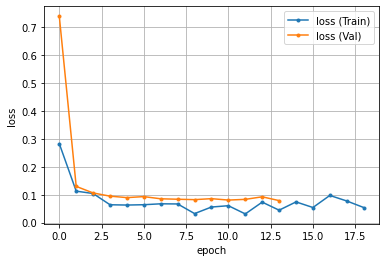

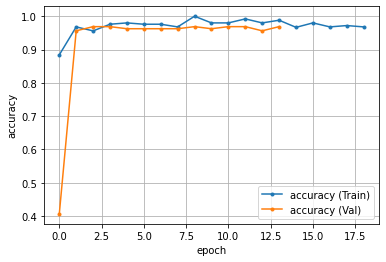

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline

# 損失
plt.plot(history['train_loss'],
         marker='.',
         label='loss (Train)')
plt.plot(history['val_loss'],
         marker='.',
         label='loss (Val)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# 精度
plt.plot(history['train_accuracy'],
         marker='.',
         label='accuracy (Train)')
plt.plot(history['val_accuracy'],
         marker='.',
         label='accuracy (Val)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

#END